In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("data_vad.csv")
data = df[(df["Valence"].notna())&(df["Arousal"].notna())].drop(["filename"], axis = 1)

# Разделение данных

In [10]:
X1 = data[data["label"] == 1]["batch_id"].unique()
X2 = data[data["label"] == 2]["batch_id"].unique()
X3 = data[data["label"] == 3]["batch_id"].unique()

X1_train, X1_test = train_test_split(X1,train_size = 0.7, random_state = 42)
X2_train, X2_test = train_test_split(X2,train_size = 0.7, random_state = 42)
X3_train, X3_test = train_test_split(X3,train_size = 0.7, random_state = 42)
X_train = [*X1_train, *X2_train, *X3_train]
X_test = [*X1_test, *X2_test, *X3_test]
data_train = data[data["batch_id"].apply(lambda x: x in X_train)]
data_test = data[data["batch_id"].apply(lambda x: x in X_test)]

X = data_train.iloc[:,1:4]
X_test = data_test.iloc[:,1:4]
y_valence = data_train.iloc[:,4:5]
y_arousal = data_train.iloc[:,5:6]
y_valence_test = data_test.iloc[:,4:5]
y_arousal_test = data_test.iloc[:,5:6]

# Модели из коробки

In [11]:
def models_test(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(),  
              KNeighborsRegressor(), 
              DecisionTreeRegressor(),
              RandomForestRegressor(),
              GradientBoostingRegressor(),
              CatBoostRegressor(iterations = 100, learning_rate = 0.1, depth = 3), 
              LGBMRegressor(max_depth = 3), 
              XGBRegressor(n_estimators = 100, max_depth = 3)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [8]:
TestModelsArousal = models_test(X, y_arousal, X_test, y_arousal_test)
TestModelsValence = models_test(X, y_valence, X_test, y_valence_test)

0:	learn: 0.1045332	total: 152ms	remaining: 15s
1:	learn: 0.1032021	total: 153ms	remaining: 7.49s
2:	learn: 0.1019502	total: 154ms	remaining: 4.97s
3:	learn: 0.1008763	total: 154ms	remaining: 3.7s
4:	learn: 0.0999735	total: 155ms	remaining: 2.94s
5:	learn: 0.0991757	total: 156ms	remaining: 2.44s
6:	learn: 0.0985413	total: 156ms	remaining: 2.08s
7:	learn: 0.0979092	total: 157ms	remaining: 1.81s
8:	learn: 0.0973507	total: 158ms	remaining: 1.59s
9:	learn: 0.0968530	total: 158ms	remaining: 1.42s
10:	learn: 0.0964629	total: 159ms	remaining: 1.28s
11:	learn: 0.0961175	total: 159ms	remaining: 1.17s
12:	learn: 0.0958573	total: 160ms	remaining: 1.07s
13:	learn: 0.0956191	total: 161ms	remaining: 987ms
14:	learn: 0.0953429	total: 161ms	remaining: 914ms
15:	learn: 0.0948935	total: 162ms	remaining: 849ms
16:	learn: 0.0945963	total: 162ms	remaining: 793ms
17:	learn: 0.0942634	total: 163ms	remaining: 743ms
18:	learn: 0.0939571	total: 164ms	remaining: 698ms
19:	learn: 0.0937903	total: 164ms	remaining:

# Модели после подбора параметров

In [12]:
def models_test_val(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(kernel = 'linear'),  
              KNeighborsRegressor(n_neighbors = 59), 
              DecisionTreeRegressor(max_depth = 4),
              RandomForestRegressor(max_depth = 4, max_features = 6, n_estimators = 200),
              GradientBoostingRegressor(max_depth = 3, n_estimators = 100),
              CatBoostRegressor(iterations = 200, depth = 2), 
              LGBMRegressor(max_depth = 2, n_estimators = 100), 
              XGBRegressor(n_estimators = 100, max_depth = 2)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)
MTV = models_test_val(X, y_valence, X_test, y_valence_test)

Learning rate set to 0.175101
0:	learn: 0.3627017	total: 723us	remaining: 144ms
1:	learn: 0.3508306	total: 1.25ms	remaining: 123ms
2:	learn: 0.3419684	total: 1.77ms	remaining: 116ms
3:	learn: 0.3360012	total: 2.34ms	remaining: 115ms
4:	learn: 0.3307004	total: 2.84ms	remaining: 111ms
5:	learn: 0.3261243	total: 3.5ms	remaining: 113ms
6:	learn: 0.3211776	total: 4.04ms	remaining: 112ms
7:	learn: 0.3188105	total: 4.59ms	remaining: 110ms
8:	learn: 0.3154278	total: 5.07ms	remaining: 108ms
9:	learn: 0.3137592	total: 5.6ms	remaining: 106ms
10:	learn: 0.3120092	total: 6.12ms	remaining: 105ms
11:	learn: 0.3102223	total: 6.63ms	remaining: 104ms
12:	learn: 0.3088284	total: 7.13ms	remaining: 103ms
13:	learn: 0.3064046	total: 7.64ms	remaining: 102ms
14:	learn: 0.3054928	total: 8.15ms	remaining: 101ms
15:	learn: 0.3039001	total: 8.65ms	remaining: 99.5ms
16:	learn: 0.3035631	total: 9.16ms	remaining: 98.6ms
17:	learn: 0.3026519	total: 9.75ms	remaining: 98.6ms
18:	learn: 0.3021422	total: 10.3ms	remaining

In [13]:
def models_test_ar(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(kernel = 'linear'),  
              KNeighborsRegressor(n_neighbors = 102), 
              DecisionTreeRegressor(max_depth = 2),
              RandomForestRegressor(max_depth = 3, n_estimators = 200, max_features = 1),
              GradientBoostingRegressor(max_depth = 1, n_estimators = 100),
              CatBoostRegressor(iterations = 600, depth = 1), 
              LGBMRegressor(max_depth = 1, n_estimators = 100), 
              XGBRegressor(n_estimators = 100, max_depth = 1)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)
MTA = models_test_ar(X, y_arousal, X_test, y_arousal_test)

Learning rate set to 0.071679
0:	learn: 0.1050571	total: 714us	remaining: 428ms
1:	learn: 0.1045483	total: 1.34ms	remaining: 402ms
2:	learn: 0.1039209	total: 1.95ms	remaining: 388ms
3:	learn: 0.1033760	total: 2.57ms	remaining: 382ms
4:	learn: 0.1029148	total: 3.19ms	remaining: 380ms
5:	learn: 0.1025349	total: 3.78ms	remaining: 374ms
6:	learn: 0.1020946	total: 4.41ms	remaining: 373ms
7:	learn: 0.1016361	total: 5.02ms	remaining: 372ms
8:	learn: 0.1013045	total: 5.66ms	remaining: 372ms
9:	learn: 0.1009933	total: 6.29ms	remaining: 371ms
10:	learn: 0.1007014	total: 6.92ms	remaining: 371ms
11:	learn: 0.1004251	total: 7.54ms	remaining: 369ms
12:	learn: 0.1001397	total: 8.15ms	remaining: 368ms
13:	learn: 0.0998971	total: 8.76ms	remaining: 366ms
14:	learn: 0.0996716	total: 9.18ms	remaining: 358ms
15:	learn: 0.0994574	total: 9.53ms	remaining: 348ms
16:	learn: 0.0992778	total: 9.86ms	remaining: 338ms
17:	learn: 0.0991006	total: 10.2ms	remaining: 330ms
18:	learn: 0.0989453	total: 10.5ms	remaining:

481:	learn: 0.0925544	total: 169ms	remaining: 41.5ms
482:	learn: 0.0925527	total: 170ms	remaining: 41.2ms
483:	learn: 0.0925510	total: 170ms	remaining: 40.8ms
484:	learn: 0.0925492	total: 171ms	remaining: 40.5ms
485:	learn: 0.0925473	total: 171ms	remaining: 40.1ms
486:	learn: 0.0925459	total: 171ms	remaining: 39.8ms
487:	learn: 0.0925441	total: 172ms	remaining: 39.4ms
488:	learn: 0.0925427	total: 172ms	remaining: 39.1ms
489:	learn: 0.0925416	total: 173ms	remaining: 38.8ms
490:	learn: 0.0925404	total: 173ms	remaining: 38.4ms
491:	learn: 0.0925384	total: 173ms	remaining: 38.1ms
492:	learn: 0.0925367	total: 174ms	remaining: 37.7ms
493:	learn: 0.0925349	total: 174ms	remaining: 37.4ms
494:	learn: 0.0925327	total: 175ms	remaining: 37ms
495:	learn: 0.0925308	total: 175ms	remaining: 36.7ms
496:	learn: 0.0925290	total: 175ms	remaining: 36.3ms
497:	learn: 0.0925271	total: 176ms	remaining: 36ms
498:	learn: 0.0925255	total: 176ms	remaining: 35.7ms
499:	learn: 0.0925243	total: 177ms	remaining: 35.3

# Сравнение

In [14]:
TestModelsArousal['Params'] = ["No"]*12
MTV['Params'] = ["Yes"]*12
df_Valence = TestModelsArousal.append(MTV)

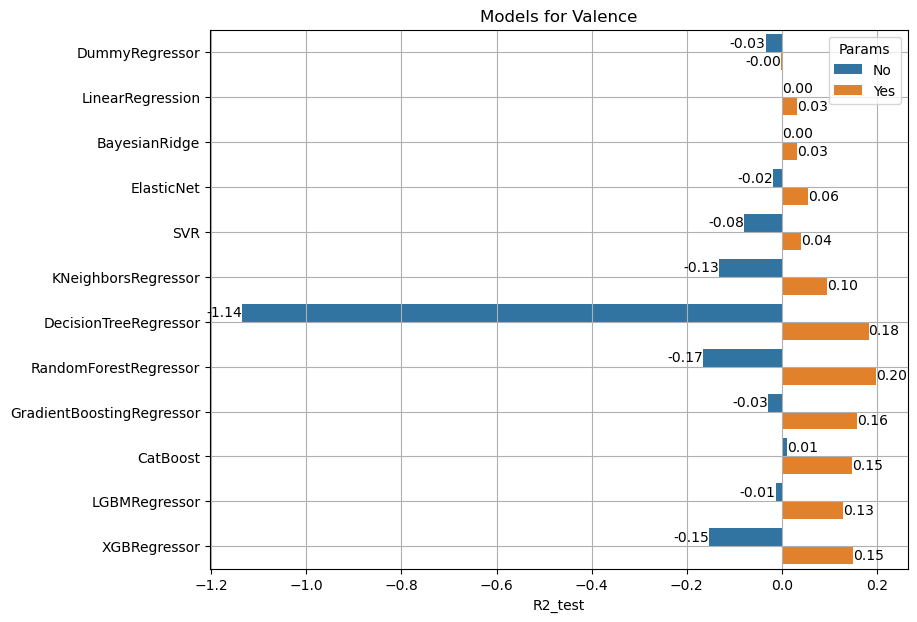

In [15]:
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.barplot(data = df_Valence, x = 'R2_test', y = df_Valence.index, hue = 'Params')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.grid()
plt.title('Models for Valence')
plt.show()

In [16]:
TestModelsArousal['Params'] = ["No"]*12
MTA['Params'] = ["Yes"]*12
df_Arousal = TestModelsArousal.append(MTA)

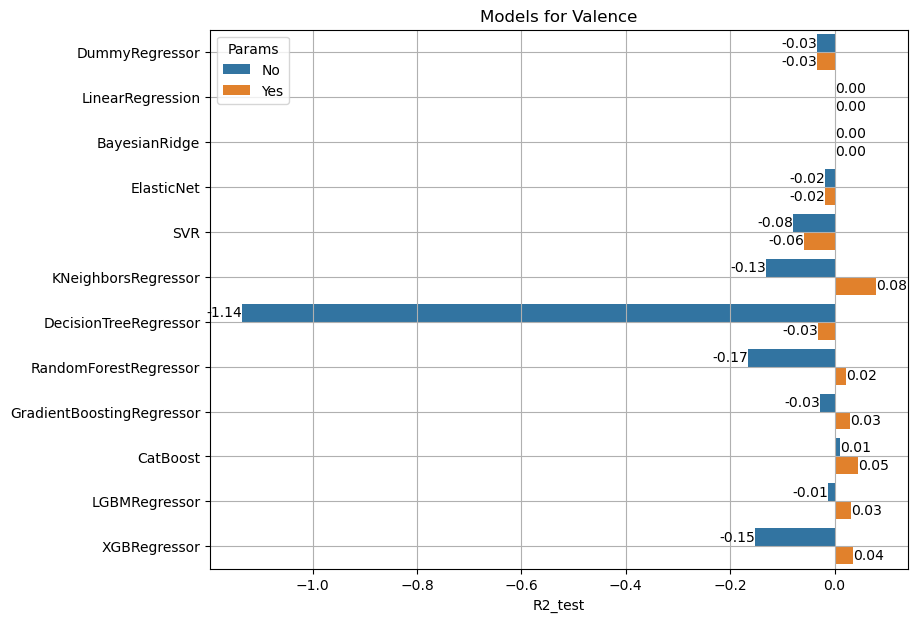

In [17]:
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.barplot(data = df_Arousal, x = 'R2_test', y = df_Arousal.index, hue = 'Params')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.grid()
plt.title('Models for Valence')
plt.show()